# Wine quality data modelling

Our goal in this phase is to look for a modelling approach that might enable us to predict the reported wine quality grade within an acceptable range based on a wine's physiochemical characteristics. For our project, we will set the acceptable range at ±1.
To this end, we will first pre-process the data set to facilitate machine-learning-based modelling, then we will train several models to look into the best fit. The models we will focus on are:
* A baseline naive Bayes classifier model
* A Stochastic Gradient Descent regression model
* A Decision Tree classifier model
* A Support Vector Machine classifier model
* A Neural Network classifier model

In [1]:
import pandas as pd #Data frames and data wrangling
import numpy as np #Data wrangling
from sklearn.preprocessing import StandardScaler #Preprocessing step: standard scaling
from sklearn.model_selection import GridSearchCV, train_test_split #Grid search and set splitting
from sklearn import linear_model, svm, tree #Scikit-learn models to be used
from sklearn.neural_network import MLPClassifier #Neural network classifier
from sklearn.metrics import confusion_matrix, accuracy_score #Model scoring
import seaborn as sns #To plot confusion matrix
import matplotlib.pyplot as plt #Plotting

In [2]:
#Function to assess +/- 1 accuracy condition
def near_accuracy(Y_act, Y_hat):
    """
    This function returns the share of values from the predicted outcomes
    that match the actual outcomes +/- 1.
    
    Parameters
    ----------
    Y_act = list or array of actual outcomes
    Y_hat = list or array of predicted outcomes
    
    Returns
    -------
    near_accuracy_val = proportion of predicted outcomes within +/- 1 of the actual outcomes
    """
    Y_near = [] #Empty list
    try: 
        for i in range(0, Y_hat.size): #Iterate through the index of Y_hat
            Y_near.append(Y_hat[i] in range(Y_act[i]-1, Y_act[i]+2)) #Append True if value found in +/-1 range of actuals
        near_accuracy_val = sum(Y_near)/np.size(Y_near) #Get the ratio of True values
        return near_accuracy_val #Return this ratio as a result
    except IndexError:
        print("Both actual outcomes and predicted outcomes need to have the same size") #To ensure both sets have the same size

In [3]:
#Function to plot the confusion matrix as a dataframe
def cm_table(Y_act, Y_hat, values):
    """
    This function returns a dataframe of the confusion matrix, whose i-th row and 
    j-thcolumn entry indicates the number of samples with true label being i-th 
    class and predicted label being j-th class
    """
    cm = confusion_matrix(Y_act, Y_hat) #Get the raw confusion matrix
    cm_df = pd.DataFrame( #Transform it into a dataframe
        cm, #Confusion matrix
        columns = values, #Name the columns
        index = values #Name the rows
    )
    return cm_df #Return the matrix as dataframe with named columns and rows

## Data pre-processing

This step involves:
1. Importing the data set
2. Splitting it into a set of predictors (X), and a set of outcomes (Y)
3. Standard scaling the predictors set, to facilitate machine learning processing
4. Splitting the data between a training set (X_train, Y_train) and a test set (X_test, Y_test), with the test set containing 20% of all observations
5. Visually ensuring that both sets are balanced

In [4]:
wine_data = pd.read_csv("https://raw.githubusercontent.com/SPariente/wine_quality/master/winequality-red.csv") #Import data set

In [5]:
X = wine_data.drop('quality', axis = 1) #Assign the predictors to X
Y = wine_data['quality'].to_numpy() #Assign the outcomes to Y as a numpy array

In [6]:
X = StandardScaler().fit(X).transform(X) #Standard scaling of the variables in X

In [7]:
#Split the sets into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split( 
    X,
    Y,
    test_size = 0.2, #20% kept for testing
    random_state = 0 #Set random state for replicability
)

In [8]:
#Check if both sets contain at least 1 occurence of all outcomes
if all(np.sort(pd.unique(Y_train)) == np.sort(pd.unique(Y_test))):
    print("The training set and the test set both contain at least one occurence of all possible outcomes.")
else:
    print("Either the training set or the test set are missing a possible outcome.")

The training set and the test set both contain at least one occurence of all possible outcomes.


In [9]:
#Visualize the distribution across both sets of outcomes, to ensure none are over represented
print("Test set:")
print(np.bincount(Y_test)[3:9] / np.bincount(wine_data['quality'])[3:9]) #np.bincount used as the outcomes are consecutive integers
print("Training set:")
print(np.bincount(Y_train)[3:9] / np.bincount(wine_data['quality'])[3:9])

Test set:
[0.2        0.20754717 0.19823789 0.22257053 0.13567839 0.16666667]
Training set:
[0.8        0.79245283 0.80176211 0.77742947 0.86432161 0.83333333]


## Data modelling

As mentioned earlier, several models will be explored in an effort to find the best one among them.

### Baseline

As a baseline, we will use a naive Bayes approach, where each prediction will be a random integer between 3 and 8 (the values in our data set), assigned with a probability based on the observed frequency in our data set for each outcome.

In [10]:
#Get the observed probability by outcome
qual_odds = np.bincount(wine_data['quality'])[3:9] / wine_data.shape[0] #Probability = count of each outcome divided by the total number of observations
print(qual_odds)

[0.00625391 0.03314572 0.42589118 0.39899937 0.12445278 0.01125704]


In [11]:
np.random.seed(5) #Set seed for replicability
Y_nbayes = np.random.choice( #Random sampling in a given list
    a = [i for i in range(3,9)], #List = integers between 3 and 8
    size = Y_test.size, #Number of samples to make
    replace = True, #With replacement
    p = qual_odds #Probability for each outcome = observed probability
)

In [12]:
acc_table = dict() #Initialise empty dictionary to use as comparison table later on

In [13]:
acc = accuracy_score(Y_test, Y_nbayes) #Get the accuracy score
n_acc = near_accuracy(Y_test, Y_nbayes) #Get the +/-1 accuracy score
acc_table.update( #Add values to the comparison table
    dict(
        Baseline = [acc, n_acc]
    )
)

In [14]:
print("The resulting accuracy on the test set is: "+str(acc))
print("The resulting accuracy within ± 1 on the test set is: "+str(n_acc))

The resulting accuracy on the test set is: 0.36875
The resulting accuracy within ± 1 on the test set is: 0.86875


In [15]:
cm_nbayes = cm_table(Y_test, Y_nbayes, [i for i in range(3,9)]) #Plot the confusion matrix
cm_nbayes

,3,4,5,6,7,8
3,0,1,1,0,0,0
4,0,0,7,4,0,0
5,3,6,57,53,14,2
6,0,6,61,56,18,1
7,0,1,8,12,5,1
8,0,0,2,0,1,0


### Stochastic Gradient Descent (SGD)

Next, we will look at a regression model in the form of a SGD. To fit this model, a grid search will be performed across several parameters, using the training set.
To assess the accuracy of this model, the resulting predictions based on the test set will first be rounded to the nearest integer between 3 and 8.

In [16]:
#Model fitting
sgd = linear_model.SGDRegressor(random_state = 5) #Initialise the regression model

params = dict( #define parameters for the grid search
    loss = ['squared_loss', 'huber'], #Loss function
    penalty = ['l2', 'l1', 'elasticnet'], #Penalty to be used
    alpha = [0.001, 0.01, 0.1] #Alpha regularization term multiplicator
)

sgd_model = GridSearchCV( #Initialise the grid serch
    sgd, #Model
    params, #Parameters to search through
    cv = np.bincount(Y_train)[3:9].min(), #cross-validation = minimum population of outcomes
    n_jobs = 10, #10 parallel jobs
    scoring = "neg_mean_squared_error" #mean squared error used for scoring the grid search
)
sgd_model.fit( #Fit the model with the grid search
    X_train, #Training set
    Y_train #Training set
)

GridSearchCV(cv=8, estimator=SGDRegressor(random_state=5), n_jobs=10,
             param_grid={'alpha': [0.001, 0.01, 0.1],
                         'loss': ['squared_loss', 'huber'],
                         'penalty': ['l2', 'l1', 'elasticnet']},
             scoring='neg_mean_squared_error')

In [17]:
print("The best parameters found are:")
sgd_model.best_params_

The best parameters found are:


{'alpha': 0.1, 'loss': 'squared_loss', 'penalty': 'l2'}

In [18]:
#Prediction on test set
Y_sgd = sgd_model.predict(X_test).round() #Predict and round to nearest integer
Y_sgd[Y_sgd <= 2] = 3 #Set results below 3 to 3 (minimum in our data set)
Y_sgd[Y_sgd >= 9] = 8 #Set results above 8 to 8 (maximum in our data set)

In [19]:
acc = accuracy_score(Y_test, Y_sgd) #Get the accuracy score
n_acc = near_accuracy(Y_test, Y_sgd) #Get the +/-1 accuracy score
acc_table.update( #Add values to the comparison table
    dict(
        SGD = [acc, n_acc]
    )
)

In [20]:
cm_sgd = cm_table(Y_test, Y_sgd, [i for i in range(3,9)])
cm_sgd

,3,4,5,6,7,8
3,0,0,2,0,0,0
4,0,0,6,5,0,0
5,0,0,98,37,0,0
6,0,0,40,96,6,0
7,0,0,1,19,7,0
8,0,0,0,1,2,0


### Decision tree

Next, we will look into fitting a decision tree classifier to our data set. Again, a grid search will first be performed across several parameters to find the best fit using the training set.

In [21]:
#Model fitting
tree_class = tree.DecisionTreeClassifier(random_state = 5) #Initialise the decision tree classifier
params = dict(
    criterion = ['gini', 'entropy'], #Quality measure of a split
    splitter = ["best", "random"], #Strategy used to split each node
    max_features = ["auto", None] #Maximum number of features to look for
)
tree_model = GridSearchCV( #Initialise the grid search
    tree_class, #Model
    params, #Parameters
    cv = np.bincount(Y_train)[3:9].min(), #cross-validation = minimum population of outcomes
    n_jobs = 10, #10 parallel jobs
    scoring = 'balanced_accuracy' #balanced accuracy used for scoring, as the sets are imbalanced, with many more observations in the mid-range than in the extremes
)

tree_model.fit( #Fit the model with the grid search
    X_train,
    Y_train
)

GridSearchCV(cv=8, estimator=DecisionTreeClassifier(random_state=5), n_jobs=10,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', None],
                         'splitter': ['best', 'random']},
             scoring='balanced_accuracy')

In [22]:
print("The best parameters found are:")
tree_model.best_params_

The best parameters found are:


{'criterion': 'entropy', 'max_features': 'auto', 'splitter': 'best'}

In [23]:
#Prediction on test set
Y_tree = tree_model.predict(X_test)
acc = accuracy_score(Y_test, Y_tree) #Get the accuracy score
n_acc = near_accuracy(Y_test, Y_tree) #Get the +/-1 accuracy score
acc_table.update( #Add values to the comparison table
    dict(
        Tree = [acc, n_acc]
    )
)

In [24]:
cm_tree = cm_table(Y_test, Y_tree, [i for i in range(3,9)])
cm_tree

,3,4,5,6,7,8
3,0,0,1,1,0,0
4,0,0,8,2,1,0
5,0,4,89,36,6,0
6,0,0,28,97,17,0
7,0,0,4,6,13,4
8,0,0,0,2,1,0


### Support vector machine (SVM)

The next model we will look into is a SVM classifier. Again, a grid search will first be performed across several parameters to find the best fit using the training set.

In [25]:
#Model fitting
svm_class = svm.SVC(random_state = 5) #Initialise the SVM

params = dict(
    C = [1, 0.5, 0.25], #Regularization parameter
    kernel= ['linear', 'poly', 'rbf', 'sigmoid'], #Kernel to bne used
    degree = [i for i in range(1,5)], #Polynomial kernel degree to be used
    break_ties = [True, False] #Whether to break ties according to confidence value of decision function
)

svm_model = GridSearchCV( #Initialise the grid search
    svm_class, #Model
    params, #Parameters
    cv = np.bincount(Y_train)[3:9].min(), #cross-validation = minimum population of outcomes
    n_jobs = 10, #10 parallel jobs
    scoring = 'balanced_accuracy' #balanced accuracy used for scoring, as the sets are imbalanced, with many more observations in the mid-range than in the extremes
)

svm_model.fit( #Fit the model with the grid search
    X_train, 
    Y_train
)

GridSearchCV(cv=8, estimator=SVC(random_state=5), n_jobs=10,
             param_grid={'C': [1, 0.5, 0.25], 'break_ties': [True, False],
                         'degree': [1, 2, 3, 4],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='balanced_accuracy')

In [26]:
print("The best parameters found are:")
svm_model.best_params_

The best parameters found are:


{'C': 1, 'break_ties': False, 'degree': 3, 'kernel': 'poly'}

In [27]:
#Prediction on test set
Y_svm = svm_model.predict(X_test)
acc = accuracy_score(Y_test, Y_svm) #Get the accuracy score
n_acc = near_accuracy(Y_test, Y_svm) #Get the +/-1 accuracy score
acc_table.update( #Add values to the comparison table
    dict(
        SVM = [acc, n_acc]
    )
)

In [28]:
cm_svm = cm_table(Y_test, Y_svm, [i for i in range(3,9)])
cm_svm

,3,4,5,6,7,8
3,0,0,1,1,0,0
4,0,0,8,2,1,0
5,1,1,109,20,4,0
6,0,1,45,90,5,1
7,0,0,1,16,10,0
8,0,0,0,0,3,0


### Neural network

Our last model will be a neural network, in the form of a multi-layer perceptron classifier. Once again, a grid search will first be performed across several parameters to find the best fit using the training set.

In [29]:
#Model fitting
nn = MLPClassifier( #Initialise neural network model
    random_state = 5,
    early_stopping = True #Allow early stopping if there is no information gain
)

layer_size = X_train.shape[1] #Set the max size of the neuron layer to the number of predictors

params = dict( #Parameters
    solver = ['adam', 'lbfgs'], #Solver for weight optimisation
    activation = ['identity', 'logistic', 'tanh', 'relu'], #Activation function shape
    hidden_layer_sizes = [(layer_size,), (layer_size, layer_size, ), (round(layer_size/2), round(layer_size/2),)] #Size of the hidden layers
)

nn_model = GridSearchCV( #Initialize the grid search
    nn, #Model
    params, #Parameters
    cv = np.bincount(Y_train)[3:9].min(), #cross-validation = minimum population of outcomes
    n_jobs = 10, #10 parallel jobs
    scoring = 'balanced_accuracy' #balanced accuracy used for scoring, as the sets are imbalanced, with many more observations in the mid-range than in the extremes
)

nn_model.fit( #Fit the model with the grid search
    X_train, 
    Y_train
)

GridSearchCV(cv=8, estimator=MLPClassifier(early_stopping=True, random_state=5),
             n_jobs=10,
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'hidden_layer_sizes': [(11,), (11, 11), (6, 6)],
                         'solver': ['adam', 'lbfgs']},
             scoring='balanced_accuracy')

In [30]:
print("The best parameters found are:")
nn_model.best_params_

The best parameters found are:


{'activation': 'identity', 'hidden_layer_sizes': (11,), 'solver': 'lbfgs'}

In [31]:
#Prediction on test set
Y_nn = nn_model.predict(X_test)
acc = accuracy_score(Y_test, Y_nn) #Get the accuracy score
n_acc = near_accuracy(Y_test, Y_nn) #Get the +/-1 accuracy score
acc_table.update( #Add values to the comparison table
    dict(
        NN = [acc, n_acc]
    )
)

In [32]:
cm_nn = cm_table(Y_test, Y_nn, [i for i in range(3,9)])
cm_nn

,3,4,5,6,7,8
3,0,0,2,0,0,0
4,0,0,6,4,1,0
5,0,0,104,30,1,0
6,0,0,37,90,15,0
7,0,0,2,16,9,0
8,0,0,0,1,2,0


## Conclusion

To conclude, we can first have a look at the table of accuracy results from our different approaches.

In [33]:
pd.DataFrame(
    acc_table,
    index = ["Accuracy", "±1 accuracy"]
)

,Baseline,SGD,Tree,SVM,NN
Accuracy,0.36875,0.628125,0.621875,0.653125,0.634375
±1 accuracy,0.86875,0.971875,0.946875,0.959375,0.965625


From this table, we can see that the baseline approach scored relatively high on the ± 1 accuracy scale. This can be explained by the heavily inbalanced nature of the observed ratings, with over 82% of all ratings found between 5 and 7, i.e. within 1 rating grade from 6. The overall accuracy of this approach is however low, as would be expected.
We can also see that the SGD approach seems to score the highest on our ± 1 accuracy scale. Nevertheless, this approach does not have the best overall accuracy, which resulted from the support vector machine approach. 
To further compare the two models, we can have a look a the difference in results through the difference between both confusion matrices.

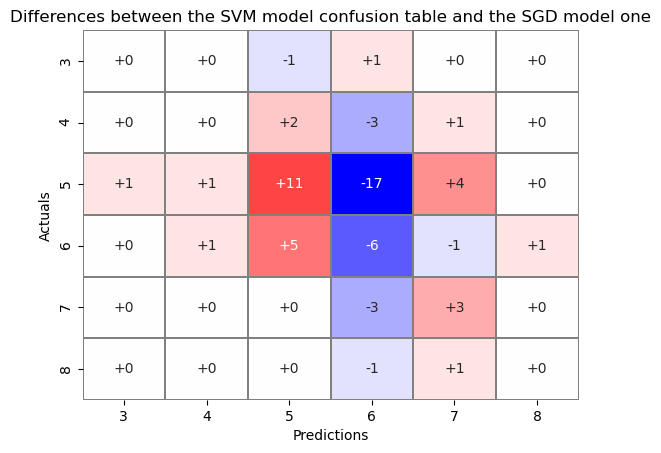

In [34]:
#Comparing both confusion matrices
cm_diff = cm_svm - cm_sgd #Difference between SVM and SGM models confusion matrices.

sns.heatmap( #Initialise heatmap
    cm_diff, #Data = difference between matrices
    center = 0, #Center on 0
    cmap = 'bwr', #High contrast color map
    annot = True, #Show differences values
    robust = True, #Color mapping based on quantiles
    linewidths = 0.1, #Show separator lines
    linecolor = 'gray', #Lines in gray
    cbar = False, #Do not show the color bar
    fmt = '+d' #Decimal format
)

plt.ylabel('Actuals')
plt.xlabel('Predictions')
plt.title("Differences between the SVM model confusion table and the SGD model one")

plt.show()

From this comparison, we can see that the SVM model performs better on ratings 7 and above, as well as 5 and below, but slightly worse on wines rated 6, which explains the lower ± 1 accuracy. Because of the inbalance in our dataset, the SGD model is still able to outperform the SVM one on the ± 1 accuracy scale, while underperforming on the high quality ratings (7-8). Both models missed all the 3 and 4 quality ratings in the test set.
Based on these observations, we would nevertheless prefer using the SVM model for predictions to the other ones, as it has a high end accuracy (65%) while also showing an above 95% result on the ± 1 accuracy metric.